In [2]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

# Experiments set-up

In [3]:
experiment       = 'synth1'
abduction        = True
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [4]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
n_varsll = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
n_varshl = len(Ghl.nodes())


omega    = mut.load_omega_map(experiment)

In [5]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [6]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [7]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [8]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

# Optimization

In [9]:
def check_for_invalid_values(matrix):
    if torch.isnan(matrix).any() or torch.isinf(matrix).any():
        #print("Matrix contains NaN or Inf values!")
        return True
    return False

def handle_nans(matrix, replacement_value=0.0):
    # Replace NaNs with a given value (default is 0)
    if torch.isnan(matrix).any():
        print("Warning: NaN values found! Replacing with zero.")
        matrix = torch.nan_to_num(matrix, nan=replacement_value)
    return matrix

In [10]:
def compute_grad_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L):

    sum_term     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float() 
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float() 

        sum_term = sum_term + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    reg_term     = 2 * lambda_L * (mu_L - hat_mu_L) # reg_term = -2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (len(Ill))) * sum_term + reg_term

    return grad_mu_L

def compute_grad_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H):

    sum_term     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float()  
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float()  

        sum_term = sum_term + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    reg_term     = 2 * lambda_H * (mu_H - hat_mu_H) # reg_term = -2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / len(Ill)) * sum_term + reg_term

    return grad_mu_H


def compute_grad_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L):

    sum_term         = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i          = torch.from_numpy(LLmodels[iota].F)
        V_i          = T @ L_i.float()

        sum_term        = sum_term + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    reg_term         = 2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt) # reg_term = -2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L     = (2 / (n+1)) * sum_term + reg_term
    
    return grad_Sigma_L

def compute_grad_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H):

    sum_term            = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i          = torch.from_numpy(HLmodels[omega[iota]].F).float()
        
        sum_term     = sum_term + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    reg_term            = 2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt) # reg_term = -2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H     = (2 / (n+1)) * sum_term + reg_term

    return grad_Sigma_H

def prox_grad_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L):

    Sigma_L               = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()  
        V_i               = oput.regmat(T @ L_i)  
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 
        
        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L).T
        
        ll_term           = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H           = Sigma_H.float()  
        H_Sigma_H         = H_i @ Sigma_H @ H_i.T

        hl_term           = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L           = Sigma_L + (ll_term * hl_term)

    Sigma_L_final         = (2 / (n+1)) * Sigma_L 
    Sigma_L_final         = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def prox_grad_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H):

    Sigma_H               = torch.zeros_like(Sigma_H_half, dtype=torch.float32)
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()
        V_i               = T @ L_i #oput.regmat(T @ L_i)
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()

        Sigma_H_half      = Sigma_H_half.float()
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H)
        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
  
        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H).T
        hl_term_iota      = torch.inverse(H_i) @ prox_Sigma_H_half @ torch.inverse(H_i).T
        
        Sigma_L           = Sigma_L.float()
        V_Sigma_V         = V_i @ Sigma_L @ V_i.T
        ll_term_iota      = torch.norm(oput.sqrtm_svd(V_Sigma_V), p='fro')

        Sigma_H           = Sigma_H + (ll_term_iota * hl_term_iota)
    
    Sigma_H_final         = (2 / (n+1)) * Sigma_H
    Sigma_H_final         = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [11]:
def optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta, num_steps_min, optimizer_T, max_grad_norm, seed, xavier):

    torch.manual_seed(seed)
    if xavier:
        T = torch.nn.init.xavier_normal_(T, gain=0.01)

    cur_mu_L    = mu_L.clone()
    cur_mu_H    = mu_H.clone()
    cur_Sigma_L = Sigma_L.clone()
    cur_Sigma_H = Sigma_H.clone()

    objective_T_step = torch.tensor(0.0)  
    T_objectives_epoch = []
   
    for step in range(num_steps_min):

        objective_iota = torch.tensor(0.0)        
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()
            
            obj_value_iota   = oput.compute_objective_value(T, L_i, H_i, cur_mu_L, cur_mu_H, cur_Sigma_L, cur_Sigma_H,
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            
            objective_iota = objective_iota + obj_value_iota

        objective_T_step = objective_iota/(n+1)
        T_objectives_epoch.append(objective_T_step)

        if torch.isnan(T).any():
            print("T contains NaN! Returning zero matrix.")
            print('Failed at step:', step+1)
            # Return zero matrix of same shape as T
            return torch.zeros_like(T), objective_T_step, T_objectives_epoch

        optimizer_T.zero_grad() 
        objective_T_step.backward(retain_graph=True)
        # Add gradient clipping before optimizer step
        if max_grad_norm < float('inf'):
            torch.nn.utils.clip_grad_norm_([T], max_grad_norm)

        optimizer_T.step()  
        #print(f"Min step {step+1}/{num_steps_min}, Objective: {objective_T_step.item()}, Gradient Norm: {torch.norm(T.grad)}")
    
    return T, objective_T_step, T_objectives_epoch


def optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                 lambda_L, lambda_H, lambda_param_L, lambda_param_H, eta, num_steps_max, epsilon, delta, seed, project_onto_gelbrich, max_grad_norm):
    
    torch.manual_seed(seed)

    cur_T = T.clone()
    theta_objectives_epoch = []
    objective_theta_step = torch.tensor(0.0)
    
    max_converged = False
    # Pre-compute constant terms
    L_matrices = {iota: torch.from_numpy(LLmodels[iota].F).float() for iota in Ill}
    H_matrices = {iota: torch.from_numpy(HLmodels[omega[iota]].F).float() for iota in Ill}
        
    # Initialize running averages for adaptive learning rate
    avg_grad_norm = 0
    beta = 0.9  # momentum factor
    
    for step in range(num_steps_max): 
        # Compute all gradients first
        grad_mu_L = compute_grad_mu_L(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L)
        grad_mu_H = compute_grad_mu_H(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H)
        grad_Sigma_L = compute_grad_Sigma_L_half(cur_T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L)
        grad_Sigma_H = compute_grad_Sigma_H_half(cur_T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H)

        # Clip gradients
        if max_grad_norm < float('inf'):
            grad_mu_L = torch.clamp(grad_mu_L, -max_grad_norm, max_grad_norm)
            grad_mu_H = torch.clamp(grad_mu_H, -max_grad_norm, max_grad_norm)
            grad_Sigma_L = torch.clamp(grad_Sigma_L, -max_grad_norm, max_grad_norm)
            grad_Sigma_H = torch.clamp(grad_Sigma_H, -max_grad_norm, max_grad_norm)

        # Compute current gradient norm
        current_grad_norm = (torch.norm(grad_mu_L) + torch.norm(grad_mu_H) + 
                           torch.norm(grad_Sigma_L) + torch.norm(grad_Sigma_H))
        
        # Update running average
        avg_grad_norm = beta * avg_grad_norm + (1 - beta) * current_grad_norm
        
        # Adjust learning rate if gradients are getting too large
        current_eta = eta
        if avg_grad_norm > 1.0:
            current_eta = eta / avg_grad_norm

        # Update parameters
        mu_L = mu_L + current_eta * grad_mu_L
        mu_H = mu_H + current_eta * grad_mu_H
        
        Sigma_L_half = Sigma_L + current_eta * grad_Sigma_L
        Sigma_H_half = Sigma_H + current_eta * grad_Sigma_H
        
        # Proximal updates
        Sigma_L = prox_grad_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L)
        Sigma_H = prox_grad_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
        
        if project_onto_gelbrich:
            mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
            mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
            
            satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
            satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
            
            oput.constraints_error_check(satisfied_L, dist_L, epsi, satisfied_H, dist_H, delt)

        objective_iota = 0
        for iota in Ill:
            obj_value_iota = oput.compute_objective_value(
                                                            cur_T, L_matrices[iota], H_matrices[iota], 
                                                            mu_L, mu_H, Sigma_L, Sigma_H,
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, 
                                                            hat_Sigma_L, hat_Sigma_H, epsilon, delta
                                                         )
            objective_iota += obj_value_iota

        objective_theta_step = objective_iota/len(Ill)
        theta_objectives_epoch.append(objective_theta_step)

        # Early stopping check
        if step > 0 and abs(theta_objectives_epoch[-1] - theta_objectives_epoch[-2]) < 1e-5:
            max_converged = True

    return mu_L, Sigma_L, mu_H, Sigma_H, objective_theta_step, theta_objectives_epoch, max_converged

def optimize_max_proxgrad(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, 
                lambda_L, lambda_H, lambda_param_L, lambda_param_H, eta, num_steps_max, epsilon, delta, seed):

    torch.manual_seed(seed)
    cur_T   = T.clone()
    # Convert inputs to torch tensors with gradients
    # mu_L    = torch.tensor(mu_L, requires_grad=True)
    # mu_H    = torch.tensor(mu_H, requires_grad=True)
    # Sigma_L = torch.tensor(Sigma_L, requires_grad=True)
    # Sigma_H = torch.tensor(Sigma_H, requires_grad=True)

    mu_L    = mu_L.clone().detach().requires_grad_(True)
    mu_H    = mu_H.clone().detach().requires_grad_(True)
    Sigma_L = Sigma_L.clone().detach().requires_grad_(True)
    Sigma_H = Sigma_H.clone().detach().requires_grad_(True)

    max_converged = False
    
    # Create optimizers for means and covariances
    optimizer_mu    = torch.optim.Adam([mu_L, mu_H], lr=eta)
    optimizer_sigma = torch.optim.Adam([Sigma_L, Sigma_H], lr=eta)
    
    theta_objectives_epoch = []
    
    for step in range(num_steps_max):
        # Zero gradients
        optimizer_mu.zero_grad()
        optimizer_sigma.zero_grad()
        
        # Compute objective for this step
        obj_values = []
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()
            
            # Compute objective value
            obj_value_iota = oput.compute_objective_value(cur_T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H, 
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            obj_values.append(obj_value_iota)
        
        # Sum objectives without in-place operations
        objective_iota = torch.stack(obj_values).sum()
        # Total objective
        objective = -(objective_iota/(n+1))
        
        # Store objective value
        theta_objectives_epoch.append(-objective.item())
        
        # Early stopping check
        if step > 0 and abs(theta_objectives_epoch[-1] - theta_objectives_epoch[-2]) < 1e-5:
            max_converged = True

        # Backward pass
        objective.backward()
        
        # Update means using optimizer
        optimizer_mu.step()
        
        # Store current Sigma values before proximal update
        Sigma_L_half = Sigma_L.detach().clone()
        Sigma_H_half = Sigma_H.detach().clone()
        
        # Update Sigma_half values using optimizer
        optimizer_sigma.step()
        
        # Manual proximal gradient steps for Sigma_L and Sigma_H
        with torch.no_grad():
            # Proximal step for Sigma_L
            Sigma_L = prox_grad_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H_half, HLmodels, lambda_param_L)
            
            # Proximal step for Sigma_H
            Sigma_H = prox_grad_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
            
            # Update the tensor values for next iteration
            Sigma_L.requires_grad_(True)
            Sigma_H.requires_grad_(True)

    return (mu_L.detach(), Sigma_L.detach(), mu_H.detach(), Sigma_H.detach(), objective.detach(), theta_objectives_epoch, max_converged)

In [12]:
def run_optimization(theta_hatL, theta_hatH, initial_theta,
                     epsilon, delta, lambda_L, lambda_H, lambda_param_L, lambda_param_H, 
                     xavier, project_onto_gelbrich, eta_min, eta_max, max_iter, num_steps_min, num_steps_max, proximal_grad,
                     tol, seed, robust_L, robust_H, grad_clip, plot_steps, plot_epochs, display_results):
    
    torch.manual_seed(seed) 

    # Start timing
    start_time = time.time()

    if not robust_L:
        epsilon = 0
    if not robust_H:
        delta = 0

    erica = robust_L or robust_H

    if not erica:
        num_steps_min = 1
    
    if grad_clip:
        max_grad_norm = 1.0
    else:
        max_grad_norm = float('inf')
    
    if xavier and not project_onto_gelbrich:
        print("Forcing projection onto Gelbrich ball!")
        project_onto_gelbrich = True
    
    max_converged = False
    #print(f"ERiCA: {erica}, XAVIER: {xavier}, PROJECT: {project_onto_gelbrich}, num_steps_min: {num_steps_min}")
    
    mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H = oput.get_initialization(theta_hatL, theta_hatH, epsilon, delta, initial_theta)

    T           = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
    condition_num_list = []
    condition_num_list.append(evut.condition_number(T.detach().numpy()))
    previous_objective = float('inf') 
    epoch_objectives   = {'T_objectives_overall': [], 'theta_objectives_overall': []}
    for epoch in tqdm(range(max_iter)): 
        
        inner_loop_objectives = {'min_objectives': [], 'max_objectives': []}
        
        # Minimize T
        T_new, objective_T, T_objectives_epoch = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                              lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta, num_steps_min, optimizer_T, max_grad_norm, seed, xavier=xavier)

        #condition_num_list.append(evut.condition_number(T_new.detach().numpy()))
        inner_loop_objectives['min_objectives'] = T_objectives_epoch
        epoch_objectives['T_objectives_overall'].append(objective_T)

        # Maximize μ, Σ
        if erica and not max_converged:  
            if proximal_grad:
                mu_L, Sigma_L, mu_H, Sigma_H, obj_theta, theta_objectives_epoch, max_converged = optimize_max_proxgrad(T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                                        lambda_L, lambda_H, lambda_param_L, lambda_param_H,
                                                                                                        eta_max, num_steps_max, epsilon, delta, seed
                                                                                                        )
            else:
                mu_L, Sigma_L, mu_H, Sigma_H, obj_theta, theta_objectives_epoch, max_converged = optimize_max(
                                                                                                T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                                                hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                                lambda_L, lambda_H, lambda_param_L, lambda_param_H,
                                                                                                eta_max, num_steps_max, epsilon, delta, seed, project_onto_gelbrich, max_grad_norm
                                                                                              )
            
            if max_converged:
                num_steps_min = 1
                print(f"Max converged at epoch {epoch+1}")
            # Store objectives
            inner_loop_objectives['max_objectives'] = theta_objectives_epoch
            epoch_objectives['theta_objectives_overall'].append(obj_theta)
    
        if plot_steps:
            oput.plot_inner_loop_objectives(inner_loop_objectives, epoch, erica)
        
        # Check convergence
        criterion = abs(previous_objective - objective_T.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break
        
        
        T                  = T_new
        previous_objective = objective_T.item()

    if plot_epochs:
        oput.plot_epoch_objectives(epoch_objectives, erica)

    paramsL      = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH      = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}
    T            = T.detach().numpy()
    end_time     = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, inner_loop_objectives, epoch_objectives, condition_num_list

In [13]:
epsilon = 4
delta   = 4

theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

seed = 42

## ERiCA optimization

### a. Manual

In [14]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': .9,
                    'lambda_H': .9,
                    'lambda_param_L': .1, #.3 
                    'lambda_param_H': .3,
                    'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                    'project_onto_gelbrich': True, #???????????????????????/
                    'eta_max': 0.001,
                    'eta_min': 0.001,
                    'max_iter': 100,
                    'num_steps_min': 5,
                    'num_steps_max': 3,
                    'proximal_grad': False,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': True,
                    'grad_clip': True,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': True
                }


params_Lerica, params_Herica, T_erica, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)

100%|██████████| 100/100 [17:40<00:00, 10.61s/it]


               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.5407 -0.2076  0.6713]
 [ 0.5085 -1.4657 -0.2055]]

Condition Number: 1.9454

Low-Level Parameters:
------------------------------
μ_L = [-0.0123  0.02    0.0047]
Σ_L = 
[[2.7298 0.     0.    ]
 [0.     0.0922 0.    ]
 [0.     0.     1.3576]]

High-Level Parameters:
------------------------------
μ_H = [0.006  0.0171]
Σ_H = 
[[2.4064 0.    ]
 [0.     2.4073]]

Optimization time: 1061.6101 seconds


In [15]:
type_to_params = {
                     'gelbrich_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     },
                     
                     'boundary_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     }
                 }

joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

['data/synth1/type_to_params.pkl']

In [16]:
# params_erica =  {
#                     'theta_hatL': theta_hatL,
#                     'theta_hatH': theta_hatH,
#                     'initial_theta': 'random',
#                     'epsilon': epsilon,
#                     'delta': delta,
#                     'lambda_L': .9,
#                     'lambda_H': .9,
#                     'lambda_param_L': .3, # when high monotonic increase for seed 42
#                     'lambda_param_H': .3,
#                     'eta_max': 0.001,
#                     'eta_min': 0.0001,
#                     'max_iter': 10,
#                     'num_steps_min': 5,
#                     'num_steps_max': 4,
#                     'proximal_grad': False,
#                     'tol': 1e-5,
#                     'seed': seed,
#                     'robust_L': True,
#                     'robust_H': True,
#                     'plot_steps': False,
#                     'plot_epochs': False,
#                     'display_results': True
#                 }

# params_Lerica, params_Herica, T_erica, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)

### b. ProxGrad

In [17]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': .9,
                    'lambda_H': .9,
                    'lambda_param_L': .1, #.3
                    'lambda_param_H': .3,
                    'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                    'project_onto_gelbrich': True,
                    'eta_max': 0.001,
                    'eta_min': 0.001,
                    'max_iter': 100,
                    'num_steps_min': 5,
                    'num_steps_max': 3,
                    'proximal_grad': True,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': True,
                    'grad_clip': False,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': True
                }

params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)

100%|██████████| 100/100 [00:12<00:00,  7.93it/s]



               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.739   0.4578  0.6216]
 [ 0.6751 -0.9623 -0.4074]]

Condition Number: 1.2365

Low-Level Parameters:
------------------------------
μ_L = [-0.3038  0.3032  0.3005]
Σ_L = 
[[5.7868 0.     0.    ]
 [0.     0.4322 0.    ]
 [0.     0.     3.1229]]

High-Level Parameters:
------------------------------
μ_H = [0.3012 0.3017]
Σ_H = 
[[4.93 0.  ]
 [0.   4.93]]

Optimization time: 12.6134 seconds


In [18]:
# type_to_params = {
#                      'gelbrich_gaussian': {
#                            'L': theta_hatL,
#                            'H': theta_hatH
#                      },
                     
#                      'boundary_gaussian': {
#                            'L': params_Lerica,
#                            'H': params_Herica
#                      }
#                  }

# joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

### ENRiCO Minimization (works) do not delete!

In [19]:
# def run_enrico_optimization_min(theta_hatL, theta_hatH, initial_theta,
#                                 epsilon, delta, lambda_L, lambda_H, lambda_param, 
#                                 eta_min, eta_max, max_iter, num_steps_min, num_steps_max,
#                                 tol, seed, robust, plot_steps, plot_epochs, display_results):
    
#     # Start timing
#     start_time = time.time()

#     torch.manual_seed(seed) 
#     torch.cuda.manual_seed_all(seed)

#     hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
#     hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

#     if initial_theta == 'gelbrich':
#         l = hat_mu_L.shape[0]
#         h = hat_mu_H.shape[0]

#         # Gelbrich initialization
#         ll_moments    = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
#         mu_L, Sigma_L = ll_moments[0]
#         mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

#         hl_moments    = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
#         mu_H, Sigma_H = hl_moments[0]
#         mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()

#     elif initial_theta == 'empirical':
#         mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
#         mu_H, Sigma_H = hat_mu_H, hat_Sigma_H
    
#     # Initialize storage
#     T_objectives = []

#     T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
#     #T = torch.from_numpy(Tau).float()
#     #optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
#     optimizer_T = torch.optim.SGD([T], lr=eta_min, momentum=0.9)
#     previous_objective = float('inf')  
#     objective_T        = torch.tensor(0.0)
#     for epoch in tqdm(range(max_iter)): 
            
#         objective_T_step = torch.tensor(0.0) #torch.tensor(0.0) # Reset objective at the start of each step
#         for n, iota in enumerate(Ill):
#             L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()
#             H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
            
#             obj_value_iota = oput.compute_objective_value(T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H,
#                                                           lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
#                                                           epsilon, delta)
            
#             objective_T_step = objective_T_step + obj_value_iota
        
#         objective_T = objective_T_step/(n+1)

#         T_objectives.append(objective_T.item())

#         if torch.isnan(T).any():
#             print("Gradient contains NaN!")
#             print('step: ', epoch+1)

#         optimizer_T.zero_grad() 
#         objective_T.backward(retain_graph=True)
#         optimizer_T.step()  

#         # Check convergence
#         criterion = abs(previous_objective - objective_T.item()) 
#         if criterion < tol:
#             print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
#             break

#         previous_objective = objective_T.item()

#     # Plot overall progress
#     # if plot_epochs == True:
#     #     oput.plot_overall_progress(T_objectives, robust)

#     paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
#     paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

#     T = T.detach().numpy()
    
#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     if display_results == True:
#         oput.print_results(T, paramsL, paramsH, elapsed_time)

#     return paramsL, paramsH, T, T_objectives

# def plot_overall_progress(objectives_list, robust=False):
#     """
#     Plot objective values over epochs from a simple list.
    
#     Args:
#         objectives_list: List of objective values per epoch
#         robust: Boolean flag (not used in this simplified version)
#     """
#     plt.figure(figsize=(10, 6))
    
#     # Create x-axis values (epoch numbers)
#     epochs = range(1, len(objectives_list) + 1)
    
#     # Plot the objectives
#     sns.lineplot(
#         x=epochs,
#         y=objectives_list,
#         color='blue',
#         label='Objective'
#     )
    
#     plt.title('Optimization Progress')
#     plt.xlabel('Epoch')
#     plt.ylabel('Objective Value')
#     plt.grid(True, alpha=0.3)
    
#     # Add markers to better see individual points
#     plt.scatter(epochs, objectives_list, color='blue', alpha=0.5, s=30)
    
#     # Scientific notation for y-axis if values are very small/large
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
#     plt.tight_layout()
#     plt.show()

# params_enrico_min =  {
#                     'theta_hatL': theta_hatL,
#                     'theta_hatH': theta_hatH,
#                     'initial_theta': 'empirical',
#                     'epsilon': .9,
#                     'delta': .8,
#                     'lambda_L': 0.9,
#                     'lambda_H': 0.9,
#                     'lambda_param': 0.9,
#                     'eta_max': 0.001,
#                     'eta_min': 0.001,
#                     'max_iter': 500,
#                     'num_steps_min': 4,
#                     'num_steps_max': 3,
#                     'tol': 1e-6,
#                     'seed': seed,
#                     'robust': True,
#                     'plot_steps': True,
#                     'plot_epochs': True,
#                     'display_results': False
#                 }

# params_Lenrico, params_Henrico, T_enrico, objs = run_enrico_optimization_min(**params_enrico_min)
# plot_overall_progress(objs)

### 2. ENRiCO optimization

In [20]:
params_enrico =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': .9,
                    'lambda_H': .9,
                    'lambda_param_L': .1, #3, # when high monotonic increase for seed 42
                    'lambda_param_H': .3,
                    'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                    'project_onto_gelbrich': False,
                    'eta_max': 0.001,
                    'eta_min': 0.001,
                    'max_iter': 100,
                    'num_steps_min': 5,
                    'num_steps_max': 3,
                    'proximal_grad': False,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': False,
                    'robust_H': False,
                    'grad_clip': False,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': True
                }

params_Lenrico, params_Henrico, T_enrico, inobjs, epobjs, condition_num_list = run_optimization(**params_enrico)

100%|██████████| 100/100 [00:01<00:00, 96.20it/s]


               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.4342  0.2327  0.3343]
 [ 0.3176 -1.0255 -0.0905]]

Condition Number: 1.8815

Low-Level Parameters:
------------------------------
μ_L = [-0.0037  0.0032  0.0005]
Σ_L = 
[[1.0055 0.     0.    ]
 [0.     0.9948 0.    ]
 [0.     0.     0.999 ]]

High-Level Parameters:
------------------------------
μ_H = [0.0012 0.0017]
Σ_H = 
[[8.5771 0.    ]
 [0.     0.2438]]

Optimization time: 1.0414 seconds


## 3. Barycentric optimization

### a.  Monge

In [21]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': 'svd',
                'initialization': 'avg',
                'autograd': False,
                'seed': seed,
                'max_iter': 100,
                'tol': 1e-5,
                'display_results': False
                }

params_Lbary, params_Hbary, T_bary = oput.barycentric_optimization(**params_bary)

### b.  Autograd

In [22]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': 'svd',
                'initialization': 'avg',
                'autograd': True,
                'seed': seed,
                'max_iter': 100,
                'tol': 1e-5,
                'display_results': False
                }

params_Lbary, params_Hbary, T_bary_auto = oput.barycentric_optimization(**params_bary)

In [23]:
joblib.dump(T_erica, f"data/{experiment}/T_erica.pkl")
joblib.dump(T_erica_prox, f"data/{experiment}/T_erica_prox.pkl")
joblib.dump(T_enrico, f"data/{experiment}/T_enrico.pkl")
joblib.dump(T_bary, f"data/{experiment}/T_bary.pkl")
joblib.dump(T_bary_auto, f"data/{experiment}/T_bary_auto.pkl")
joblib.dump(Tau, f"data/{experiment}/Tau.pkl")

['data/synth1/Tau.pkl']

# Evaluation

### Condition number comparison

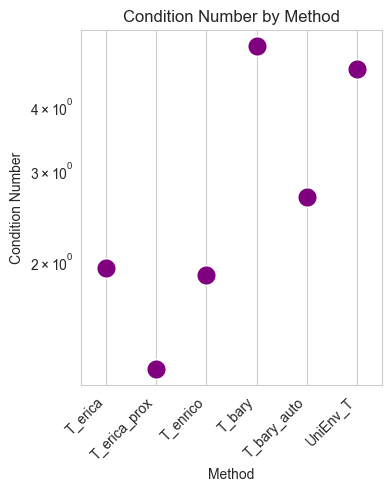

In [24]:
T_name         = ['T_erica','T_erica_prox', 'T_enrico', 'T_bary', 'T_bary_auto', 'UniEnv_T']
condition_nums = {}
for i, T in enumerate([T_erica, T_erica_prox, T_enrico, T_bary, T_bary_auto, Tau]): 
    cn = evut.condition_number(T)
    condition_nums[T_name[i]] = cn
    #print(f"For {T_name[i]} method condition number of final T = {cn}")
evut.plot_condition_nums(condition_nums)

In [25]:
data = mut.load_samples(experiment)

In [26]:
add_noiseL         = True
add_noiseH         = True
noise_typeL        = 'boundary_gaussian'
noise_typeH        = 'boundary_gaussian'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'multiplicative'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'wass'
num_iter           = 10

if noise_typeL == 'random_normal' or noise_typeH == 'random_normal':
    noise_range = (0, 1)
else:
    noise_range = None


In [27]:
methods      = ['T_erica', 'T_erica_prox', 'T_enrico', 'T_bary', 'T_bary_auto', 'Tau']
abstraction_error = {name: [] for name in methods}

# Outer loop: number of noise sampling iterations
for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"
    
    noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)
    noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)
    
    for i, method in enumerate(methods):

        T     = mut.load_abstraction(experiment, method)
        total = 0
    
        # Compute average error over Ill for this method
        for iota in Ill:
            # Get base data and add noise
            base, abst = data[iota]
            
            if add_noiseL:
                base = base + noiseL # + base 
            if add_noiseH:
                abst = abst + noiseH # + abst
                
            if lin_contaminationL:
                base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
            if lin_contaminationH:
                abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
            
            total += evut.compute_abstraction_error(T, base, abst, metric)
                        
        iter_avg = total / len(Ill)
        abstraction_error[methods[i]].append(iter_avg)

100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Average e(τ) for T_erica: 1.86 ± 0.008

Average e(τ) for T_erica_prox: 1.01 ± 0.003

Average e(τ) for T_enrico: 2.74 ± 0.009

Average e(τ) for T_bary: 9.14 ± 0.028

Average e(τ) for T_bary_auto: 3.28 ± 0.011

Average e(τ) for Tau: 4.92 ± 0.019



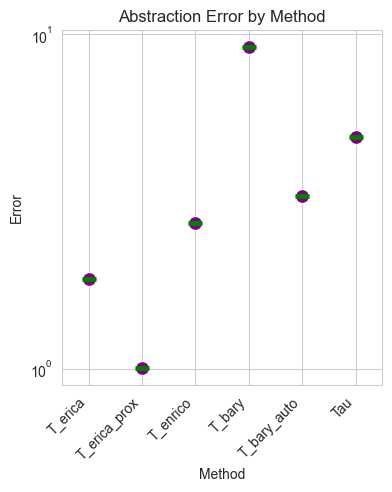

In [28]:
# Compute final statistics
final_abstraction_error = {}
for method in methods:
    mean_e = np.mean(abstraction_error[method])
    std_e = np.std(abstraction_error[method])
    final_abstraction_error[method] = (mean_e, std_e * 1.96)
    print(f"Average e(τ) for {method}: {mean_e:.2f} ± {std_e:.3f}\n")

# Plot results
evut.plot_abstraction_error(final_abstraction_error)

In [86]:

for project_onto_gelbrich in [True, False]:
    print(f"Project_onto_gelbrich: {project_onto_gelbrich}")
    params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': .9,
                    'lambda_H': .9,
                    'lambda_param_L': .1, #.3 
                    'lambda_param_H': .3,
                    'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                    'project_onto_gelbrich': project_onto_gelbrich,
                    'eta_max': 0.001,
                    'eta_min': 0.001,
                    'max_iter': 10,
                    'num_steps_min': 5,
                    'num_steps_max': 3,
                    'proximal_grad': False,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': True,
                    'grad_clip': False,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': False
                }

    params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)
    type_to_params = {
                    'gelbrich_gaussian': {
                        'L': theta_hatL,
                        'H': theta_hatH
                    },
                    
                    'boundary_gaussian': {
                        'L': params_Lerica,
                        'H': params_Herica
                    }
                }

    joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

    methods      = ['T_erica']
    abstraction_error = {name: [] for name in methods}

    # Outer loop: number of noise sampling iterations
    for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"
        
        noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)
        noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)
        
        for i, method in enumerate(methods):

            T     = mut.load_abstraction(experiment, method)
            total = 0
        
            # Compute average error over Ill for this method
            for iota in Ill:
                # Get base data and add noise
                base, abst = data[iota]
                
                if add_noiseL:
                    base = base + noiseL # + base 
                if add_noiseH:
                    abst = abst + noiseH # + abst
                    
                if lin_contaminationL:
                    base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                if lin_contaminationH:
                    abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                
                total += evut.compute_abstraction_error(T, base, abst, metric)
                            
            iter_avg = total / len(Ill)
            abstraction_error[methods[i]].append(iter_avg)

    final_abstraction_error = {}
    for method in methods:
        mean_e = np.mean(abstraction_error[method])
        std_e = np.std(abstraction_error[method])
        final_abstraction_error[method] = (mean_e, std_e * 1.96)
        print(f"Average e(τ) for {method}: {mean_e:.2f} ± {std_e:.3f}\n")
    print( )

Project_onto_gelbrich: True


100%|██████████| 10/10 [00:00<00:00, 15.85it/s]


Average e(τ) for T_erica: 2.27 ± 0.008


Project_onto_gelbrich: False


100%|██████████| 10/10 [00:00<00:00, 16.74it/s]

Average e(τ) for T_erica: 2.27 ± 0.007




In [ ]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': .9,
                    'lambda_H': .9,
                    'lambda_param_L': .3, 
                    'lambda_param_H': .3,
                    'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                    'project_onto_gelbrich': True,
                    'eta_max': 0.001,
                    'eta_min': 0.001,
                    'max_iter': 100,
                    'num_steps_min': 5,
                    'num_steps_max': 3,
                    'proximal_grad': True,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': True,
                    'grad_clip': False,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': True
                }

params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)

In [ ]:
methods      = ['T_erica', 'T_erica_prox', 'T_enrico', 'T_bary', 'T_bary_auto', 'Tau']
abstraction_error = {name: [] for name in methods}

# Outer loop: number of noise sampling iterations
for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"
    
    noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)
    noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)
    
    for i, method in enumerate(methods):

        T     = mut.load_abstraction(experiment, method)
        total = 0
    
        # Compute average error over Ill for this method
        for iota in Ill:
            # Get base data and add noise
            base, abst = data[iota]
            
            if add_noiseL:
                base = base + noiseL # + base 
            if add_noiseH:
                abst = abst + noiseH # + abst
                
            if lin_contaminationL:
                base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
            if lin_contaminationH:
                abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
            
            total += evut.compute_abstraction_error(T, base, abst, metric)
                        
        iter_avg = total / len(Ill)
        abstraction_error[methods[i]].append(iter_avg)

### Plot Gaussian shift effects

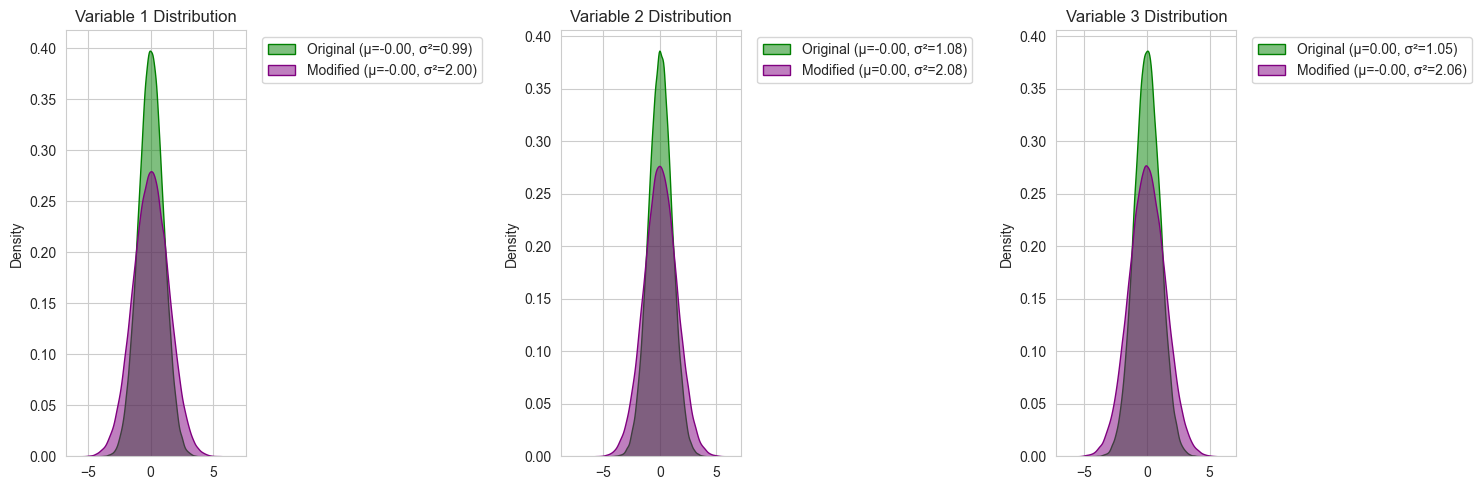

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


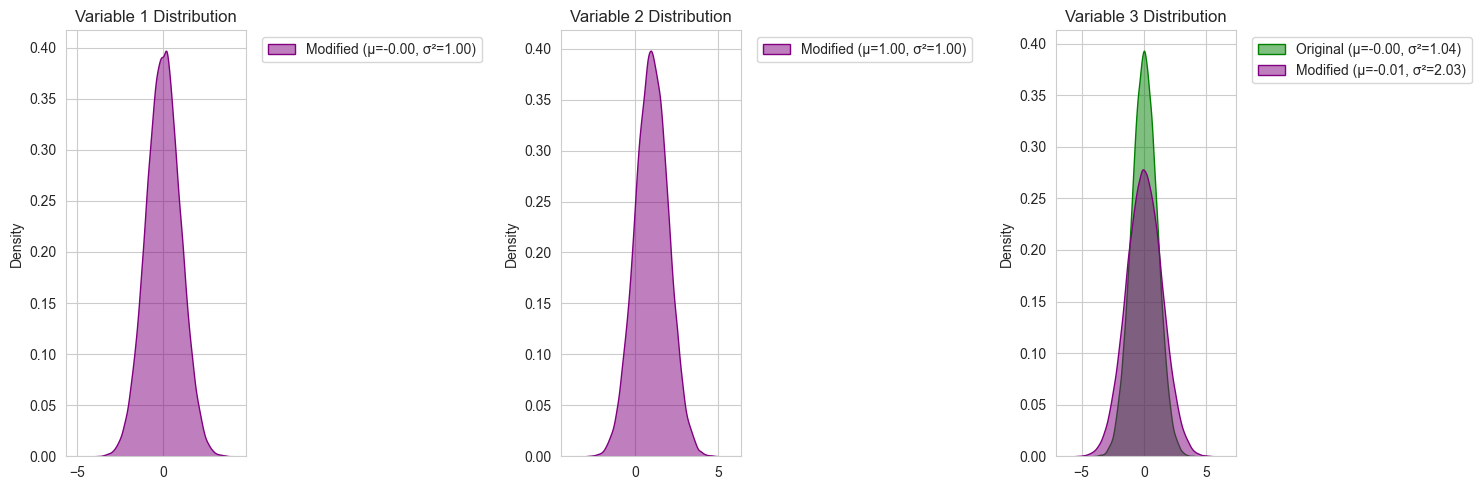

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


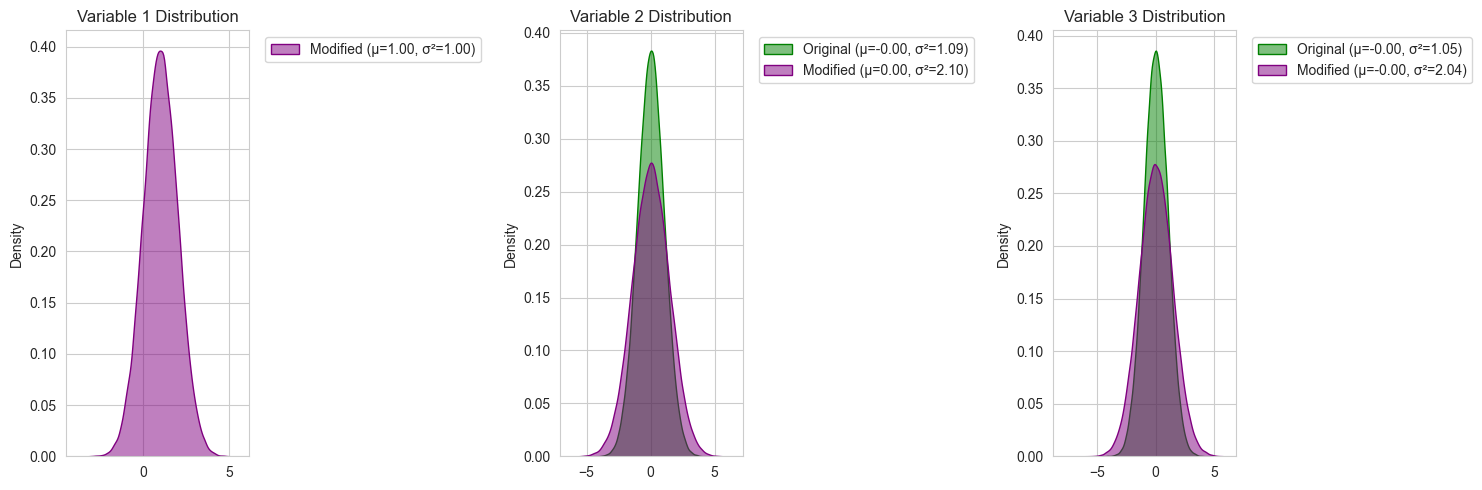

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


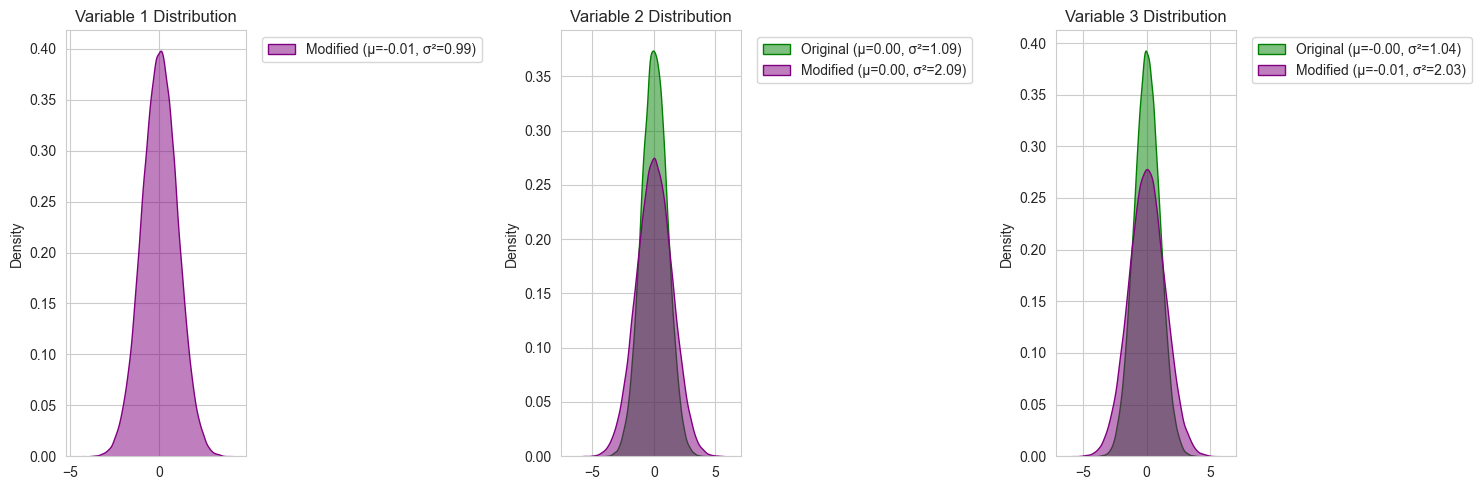

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


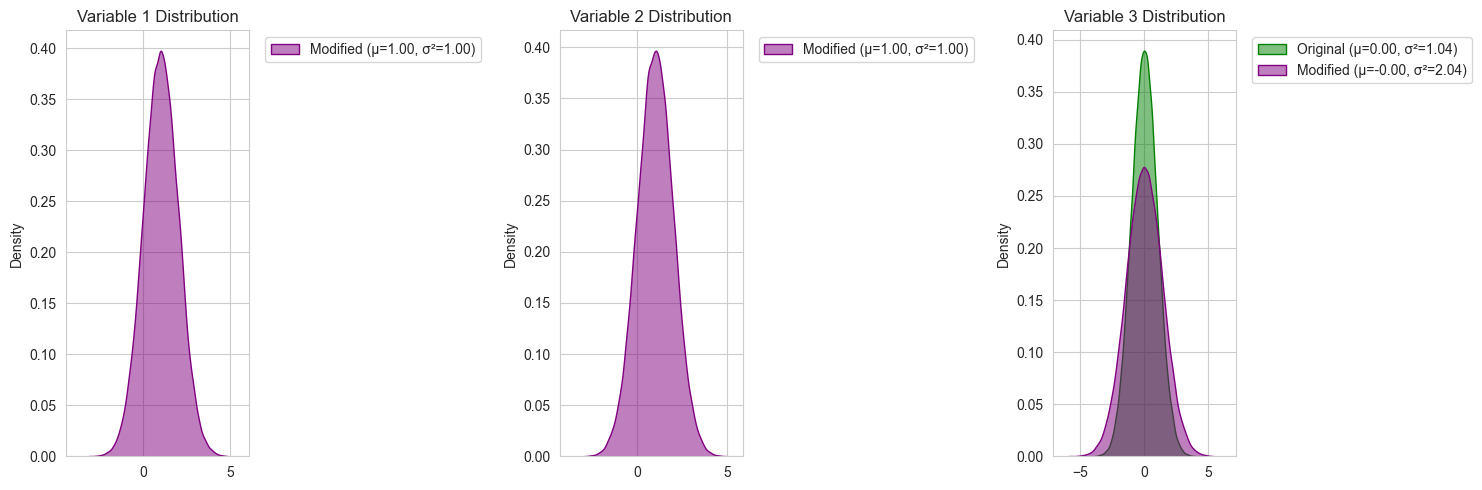

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


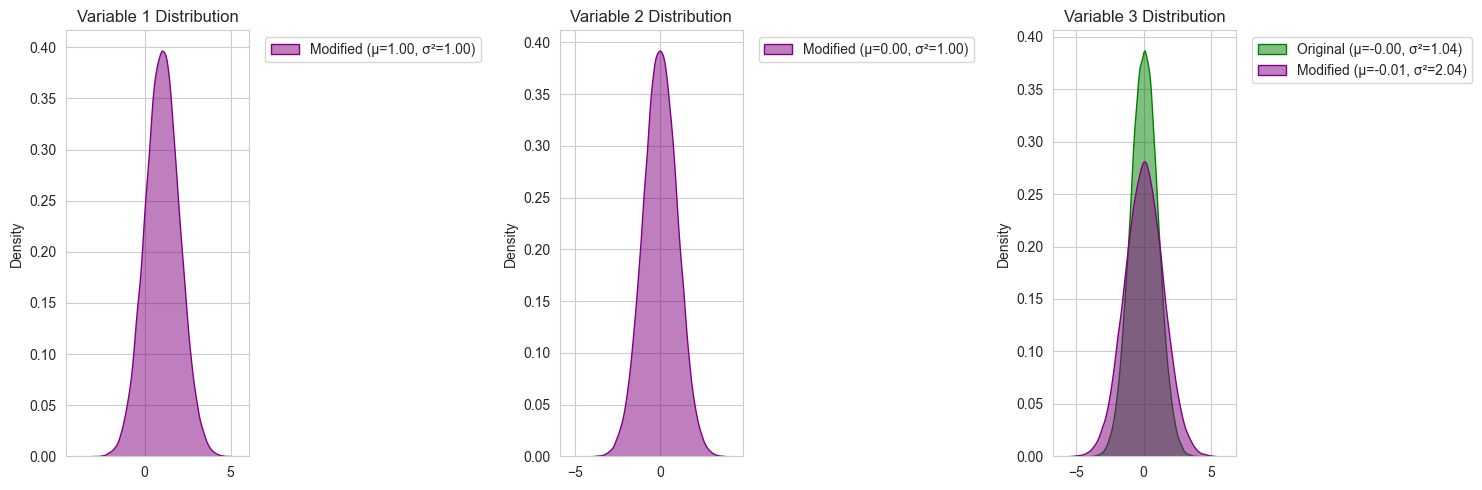

In [43]:
for iota in Ill:
    base, abst = data[iota]
    noisy_base = evut.add_random_noise(base, noise_typeL, 'L')
    evut.plot_distribution_shifts(base, noisy_base)#, f"Base Level Gaussian Shift - {noise_typeL}")
    print( )

### Plot Noise addition and linear contamination effects


In [37]:
for iota in Ill:
    base, abst = data[iota]
    #Add noise
    # base = evut.add_random_noise(base, noise_typeL, 'L')
    # abst = evut.add_random_noise(abst, noise_typeH, 'H')

    #Linear contamination
    base_c = evut.contaminate_linear_relationships(base, contamination_fraction=1, contamination_type='multiplicative')
    #abst_c = evut.contaminate_linear_relationships(abst, contamination_fraction=1, contamination_type='multiplicative')

    evut.plot_contamination_effects(base, base_c)
    print( )


## Structurally generated Gaussians (REVISE THIS!!)

In [56]:
for i, T in enumerate([T_erica, T_erica_prox, T_enrico, T_bary, T_bary_auto, Tau]): 
    all_errors = []  
    avg_error = 0
    
    for _ in range(num_iter):
        total = 0
        for iota in Ill:
            L_i = LLmodels[iota]._compute_reduced_form()
            V_i = T @ L_i
            H_i = HLmodels[omega[iota]]._compute_reduced_form()
            muV    = V_i @ params_Lerica['mu_U']
            sigmaV = V_i @ params_Lerica['Sigma_U'] @ V_i.T
            muH    = H_i @ params_Herica['mu_U']
            sigmaH = H_i @ params_Herica['Sigma_U'] @ H_i.T

            dist = mut.compute_wasserstein(muV, sigmaV, muH, sigmaH)

            total += dist

        iter_avg_ = total/len(Ill)
        all_errors.append(iter_avg_)  
 
    mean_e = np.mean(all_errors)
    std_e  = np.std(all_errors)
    print(f"Average e(τ) for {T_name[i]}: {mean_e:.6f} ± {std_e*1.96:.5f}")  

Average e(τ) for T_erica: 1.989048 ± 0.00000
Average e(τ) for T_erica_prox: 1.059072 ± 0.00000
Average e(τ) for T_enrico: 9.284983 ± 0.00000
Average e(τ) for T_bary: 7.348271 ± 0.00000
Average e(τ) for T_bary_auto: 3.240513 ± 0.00000
Average e(τ) for UniEnv  T: 5.132438 ± 0.00000


In [77]:
for epsilon in [.5, 1, 5, 10]:
    for delta in [.5, 1, 5, 10]:
        print(f"Epsilon: {epsilon}, Delta: {delta}")
        params_erica =  {
                            'theta_hatL': theta_hatL,
                            'theta_hatH': theta_hatH,
                            'initial_theta': 'empirical',
                            'epsilon': epsilon,
                            'delta': delta,
                            'lambda_L': .9,
                            'lambda_H': .9,
                            'lambda_param_L': .3, 
                            'lambda_param_H': .3,
                            'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                            'project_onto_gelbrich': True,
                            'eta_max': 0.001,
                            'eta_min': 0.001,
                            'max_iter': 10,
                            'num_steps_min': 5,
                            'num_steps_max': 3,
                            'proximal_grad': True,
                            'tol': 1e-5,
                            'seed': seed,
                            'robust_L': True,
                            'robust_H': True,
                            'plot_steps': False,
                            'plot_epochs': False,
                            'display_results': False
                        }

        params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)
        type_to_params = {
                     'gelbrich_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     },
                     
                     'boundary_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     }
                 }

        joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")
        method_names      = ['ERiCA']
        methods           = [T_erica]
        abstraction_error = {name: [] for name in method_names}

        # Outer loop: number of noise sampling iterations
        for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"
            
            noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)
            noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)
            
            # For this noise iteration, evaluate each method
            for i, T in enumerate(methods):
                total = 0
                start_time = time.time()
            
                # Compute average error over Ill for this method
                for iota in Ill:
                    # Get base data and add noise
                    base, abst = data[iota]
                    
                    if add_noiseL:
                        base = base + noiseL # + base 
                    if add_noiseH:
                        abst = abst + noiseH # + abst
                        
                    if lin_contaminationL:
                        base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                    if lin_contaminationH:
                        abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                    tau_base   = base @ T.T
                    tau_muL    = np.mean(tau_base, axis=0)
                    tau_sigmaL = np.cov(tau_base, rowvar=False)
                    muH        = np.mean(abst, axis=0)
                    sigmaH     = np.cov(abst, rowvar=False)
                    
                    if metric == 'wass':
                        dist = mut.compute_wasserstein(tau_muL, tau_sigmaL, muH, sigmaH)
                    else:  # metric == 'js'
                        dist = mut.compute_jensenshannon(tau_base, abst)
                        
                    total += dist
                    
                iter_avg = total / len(Ill)
                abstraction_error[method_names[i]].append(iter_avg)
            
        # Compute final statistics
        final_abstraction_error = {}
        for name in method_names:
            mean_e = np.mean(abstraction_error[name])
            std_e = np.std(abstraction_error[name])
            final_abstraction_error[name] = (mean_e, std_e * 1.96)
            print(f"Average e(τ) for {name}: {mean_e:.2f} ± {std_e:.3f}\n")

Epsilon: 0.5, Delta: 0.5


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_45367/4025087366.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_L    = torch.tensor(mu_L, requires_grad=True)
/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_45367/4025087366.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_H    = torch.tensor(mu_H, requires_grad=True)
/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_45367/4025087366.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Sigma_L = torch.tensor(S

Average e(τ) for ERiCA: 4.71 ± 0.014

Epsilon: 0.5, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 16.73it/s]


Average e(τ) for ERiCA: 4.71 ± 0.011

Epsilon: 0.5, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 16.43it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 0.5, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 15.57it/s]


Average e(τ) for ERiCA: 4.71 ± 0.013

Epsilon: 1, Delta: 0.5


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


Average e(τ) for ERiCA: 4.71 ± 0.018

Epsilon: 1, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 16.11it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 1, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


Average e(τ) for ERiCA: 4.70 ± 0.017

Epsilon: 1, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 16.85it/s]


Average e(τ) for ERiCA: 4.71 ± 0.009

Epsilon: 5, Delta: 0.5


100%|██████████| 10/10 [00:00<00:00, 16.83it/s]


Average e(τ) for ERiCA: 4.71 ± 0.014

Epsilon: 5, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 16.90it/s]


Average e(τ) for ERiCA: 4.71 ± 0.017

Epsilon: 5, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 10.66it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 5, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 15.48it/s]


Average e(τ) for ERiCA: 4.71 ± 0.010

Epsilon: 10, Delta: 0.5


100%|██████████| 10/10 [00:00<00:00, 16.27it/s]


Average e(τ) for ERiCA: 4.71 ± 0.014

Epsilon: 10, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Average e(τ) for ERiCA: 4.71 ± 0.012

Epsilon: 10, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 10, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 14.78it/s]

Average e(τ) for ERiCA: 4.71 ± 0.010

